In [136]:
import pandas as pd
Test=pd.read_excel('./sw 620 lib.xlsx')

Test.head()

,sgrna,Gene,control_count,treatment_count,control_mean,treat_mean,LFC,control_var,adj_var,score,p.low,p.high,p.twosided,FDR,high_in_treatment
0,sg_h1_394_s,1,549.140,25.548,549.14000,25.548,-4.37310,137070.0,26311.000,3.46190,0.000268,0.99973,0.000536,0.031897,False
1,sg_h1_322_s,1,147.220,11.108,147.22000,11.108,-3.61370,9263.3,3241.100,2.69060,0.003567,0.99643,0.007133,0.220910,False
2,sg_h1_167_s,1,0.000,0.000,0.90319,0.000,-0.92842,0.0,1.752,0.20611,0.418350,0.58165,0.836710,0.995680,False
3,sg_h1_505_s,1,0.000,0.000,0.90319,0.000,-0.92842,0.0,1.752,0.20611,0.418350,0.58165,0.836710,0.995680,False
4,sg_h1_235_a,1,37.934,0.000,37.93400,0.000,-5.28300,719.5,386.500,2.66920,0.003802,0.99620,0.007603,0.230660,False


In [137]:
# clean remove both 0 row
TestUse=Test.loc[(Test.control_count!=0) | (Test.treatment_count!=0),:]
TestUse.head()

,sgrna,Gene,control_count,treatment_count,control_mean,treat_mean,LFC,control_var,adj_var,score,p.low,p.high,p.twosided,FDR,high_in_treatment
0,sg_h1_394_s,1,549.140,25.548,549.140,25.548,-4.37310,137070.0,26311.0,3.46190,0.000268,0.99973,0.000536,0.031897,False
1,sg_h1_322_s,1,147.220,11.108,147.220,11.108,-3.61370,9263.3,3241.1,2.69060,0.003567,0.99643,0.007133,0.220910,False
4,sg_h1_235_a,1,37.934,0.000,37.934,0.000,-5.28300,719.5,386.5,2.66920,0.003802,0.99620,0.007603,0.230660,False
5,sg_h2_278_s,2,3219.900,2077.200,3219.900,2077.200,-0.63214,652880.0,447580.0,1.70800,0.043814,0.95619,0.087629,0.939850,False
6,sg_h2_612_a,2,130.960,83.309,130.960,83.309,-0.64637,1135.4,2693.5,0.93668,0.174460,0.82554,0.348920,0.995680,False


In [114]:
# wide to long
ValueDf=pd.DataFrame(TestUse.loc[:,['Gene','control_count','treatment_count']].set_index('Gene').unstack()).reset_index().rename(columns={0:'CountValue','level_0':'CountValueGroups'})

In [116]:
# raw value to Z score (for plot the histgram only)
from scipy import stats
for i in set(ValueDf.Gene):
    Dftemp=ValueDf.loc[ValueDf.Gene==i,'CountValue']
    DftempZ0=stats.zscore(Dftemp)
    ValueDf.loc[ValueDf.Gene==i,'CountValue_Ztrans']=DftempZ0


In [117]:
ValueDf.head()

,CountValueGroups,Gene,CountValue,CountValue_Ztrans
0,control_count,1,549.140,2.165574
1,control_count,1,147.220,0.096417
2,control_count,1,37.934,-0.466207
3,control_count,2,3219.900,-0.476026
4,control_count,2,130.960,-0.902711


In [150]:
set(ValueDf.CountValueGroups)

{'control_count', 'treatment_count'}

In [161]:
import seaborn as sns
import numpy as np

def plotbar(array,ax,LabelLocList,Ax_L,yName,cmap):
    g=sns.heatmap(array.reshape([1,len(array)]),
                ax=ax,cmap=cmap,
                cbar=False, yticklabels=[yName],xticklabels=[])
    g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 10)
    
    for i in LabelLocList:
        ax.axvline(x=i+0.5,linewidth=30*(Ax_L/len(array)),color='red')

def HistBarPlot(Df,ValueColumn,GeneGroupColumn,
                ValueGroupColumns,RedLine_ValueGroupName,
                PlotWide=10,NumberOfBins=50,
                Hist_cmap="skyblue",Barplot_cmap="BuGn",
                SavePNG_Path='./HistBarPlot.png'):
    GeneList=set(Df.loc[:,GeneGroupColumn])
    HistValue=Df.loc[:,ValueColumn]
    NumberOfBarPlot=len(GeneList)
    n=NumberOfBarPlot+1
     # wide of the plot
     # group of histgram
    fig, ax = plt.subplots(n, figsize=(PlotWide, n),
                           subplot_kw=dict(xticks=[], 
                                           yticks=[],
                                           frameon=False))
    
    #plot histgram
    count, bins, ignored = ax[0].hist(HistValue, NumberOfBins, 
                                      density=True,color =Hist_cmap )
    LocValueUse=np.digitize(HistValue,bins)
#     print(LocValueUse)
    NumberOfAx=1
    for i in GeneList:
        RawValueIndex_List=Df.reset_index().loc[(Df.loc[:,GeneGroupColumn]==i) & 
                                                (Df.loc[:,ValueGroupColumns]==RedLine_ValueGroupName),
                                                ValueColumn].index
#         print(RawValueIndex_List)
        LabelLocList=[LocValueUse[x] for x in RawValueIndex_List]
        plotbar(array=count,ax=ax[NumberOfAx],
                LabelLocList=LabelLocList,
                Ax_L=PlotWide,
                yName='Gene_%d' % i,
                cmap=Barplot_cmap)
        NumberOfAx+=1
    
    plt.savefig(SavePNG_Path)
    plt.show()

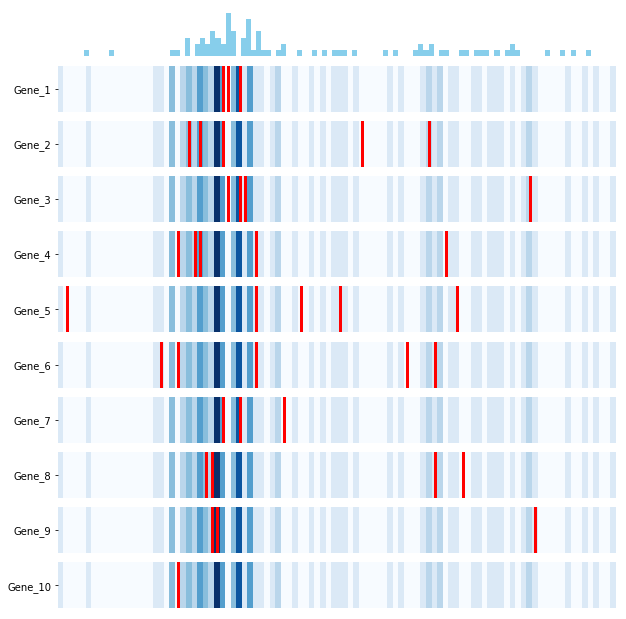

In [165]:
HistBarPlot(Df=ValueDf,
            ValueColumn='CountValue_Ztrans',
            ValueGroupColumns='CountValueGroups',RedLine_ValueGroupName='treatment_count',
            GeneGroupColumn='Gene',
            NumberOfBins=100,Hist_cmap="skyblue",Barplot_cmap="Blues",)